In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from itertools import combinations
from sklearn.model_selection import cross_validate, cross_val_score, cross_val_predict
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeRegressor
from scipy import stats

### 서포트 벡터 머신 활용 <hr>

In [3]:
file_data = '../DATA/Iris.csv'

In [4]:
irisDF = pd.read_csv(file_data)
irisDF.shape

(150, 5)

In [5]:
irisDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length  150 non-null    float64
 1   sepal_width   150 non-null    float64
 2   petal_length  150 non-null    float64
 3   petal_width   150 non-null    float64
 4   species       150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


In [6]:
irisDF['species'].unique()

array(['setosa', 'versicolor', 'virginica'], dtype=object)

In [7]:
# speciecs를 정수로 변환
irisDF.species = irisDF.species.replace({'setosa' : 0, 'versicolor' : 1, 'virginica' : 2})

In [8]:
def print_feature(nrows, ncols, target, features, corrs, df = irisDF):
    for idx in range(len(features)):
        plt.subplot(nrows, ncols, idx + 1)
        plt.scatter(df[target], df[features[idx]], label = f'corr : {corrs[idx]:.2}', color = 'cornflowerblue')
        plt.xlabel(target)
        plt.ylabel(features[idx])
        plt.legend()
    plt.tight_layout()
    plt.show()

In [9]:
corrs = []
for column in irisDF.columns[:-1]:
    corrs.append(round(stats.pointbiserialr(irisDF[column], irisDF.species).statistic, 2))
    print(f'{column}과 speicies의 상관계수 : {round(stats.pointbiserialr(irisDF[column], irisDF.species).statistic, 2)}\n')

sepal_length과 speicies의 상관계수 : 0.78

sepal_width과 speicies의 상관계수 : -0.42

petal_length과 speicies의 상관계수 : 0.95

petal_width과 speicies의 상관계수 : 0.96



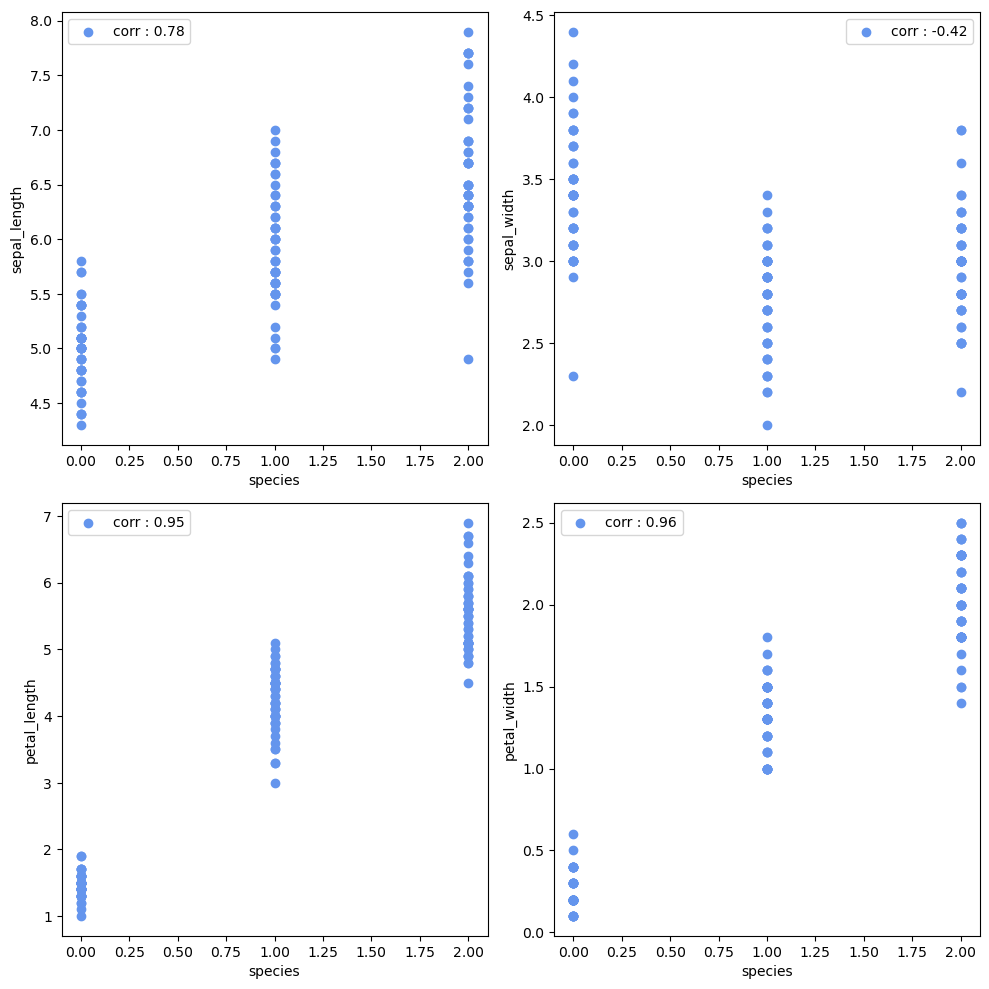

In [10]:
plt.figure(figsize = (10, 10))
print_feature(2, 2, 'species', irisDF.columns[:-1], corrs)

In [11]:
for col1, col2 in combinations(irisDF.columns[:-1], 2):
    print(col1, col2)

sepal_length sepal_width
sepal_length petal_length
sepal_length petal_width
sepal_width petal_length
sepal_width petal_width
petal_length petal_width


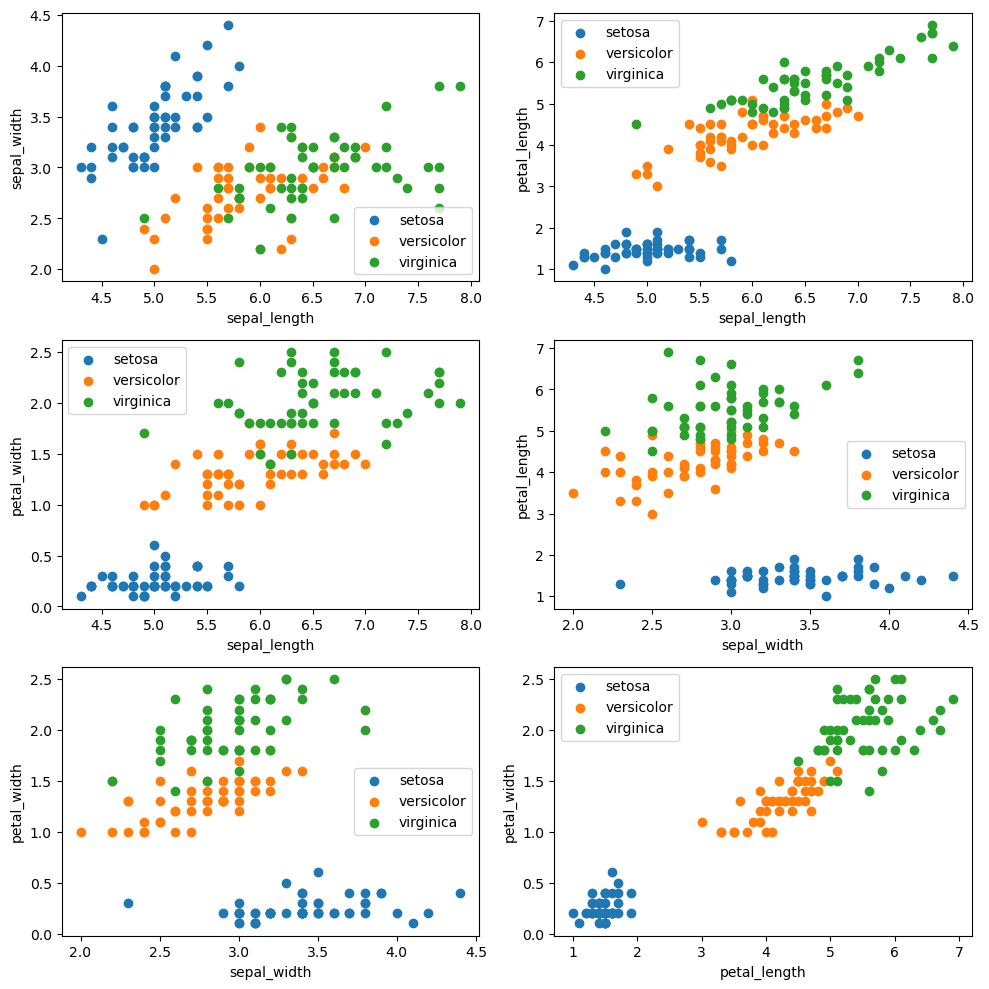

In [12]:
ind = 0
species_list = ['setosa', 'versicolor', 'virginica']
plt.figure(figsize = (10, 10))
for feature1, feature2 in combinations(irisDF.columns[:-1], 2):
    plt.subplot(3, 2, ind + 1)
    for index in range(3):
        df = irisDF[irisDF.species == index]           
        plt.scatter(df[feature1], df[feature2], label = species_list[index]) 
    plt.xlabel(feature1)
    plt.ylabel(feature2)
    plt.legend()
    ind += 1
plt.tight_layout()
plt.show()

#### 종 2개 선택하여 SVC 학습

In [13]:
twoflowerDF = irisDF[irisDF.species.isin([1, 2])]
featureDF = twoflowerDF[twoflowerDF.columns[:-1]]
targetSR = twoflowerDF.species

In [14]:
X_train, X_test, y_train, y_test = train_test_split(featureDF, targetSR, test_size = 0.2, random_state = 6, stratify = targetSR)

In [15]:
my_scaler = StandardScaler()
my_scaler.fit(X_train)
scaled_X_train = my_scaler.transform(X_train)
scaled_X_test = my_scaler.transform(X_test) 

In [16]:
lsvc = LinearSVC(dual = True)
lsvc.fit(scaled_X_train, y_train)
lsvc.score(scaled_X_train, y_train), lsvc.score(scaled_X_test, y_test)

(0.975, 0.95)

In [17]:
# 학습/검증에 대한 평가 모든 결과에 대한 처리
result = cross_validate(lsvc,
                        scaled_X_train,
                        y_train,
                        scoring = ('accuracy', 'roc_auc'),
                        return_train_score = True,
                        return_estimator = True)
result

{'fit_time': array([0., 0., 0., 0., 0.]),
 'score_time': array([0.        , 0.01500702, 0.        , 0.        , 0.        ]),
 'estimator': [LinearSVC(dual=True),
  LinearSVC(dual=True),
  LinearSVC(dual=True),
  LinearSVC(dual=True),
  LinearSVC(dual=True)],
 'test_accuracy': array([0.75  , 0.9375, 1.    , 1.    , 0.9375]),
 'train_accuracy': array([0.96875 , 1.      , 0.96875 , 0.96875 , 0.984375]),
 'test_roc_auc': array([0.9375  , 0.984375, 1.      , 1.      , 1.      ]),
 'train_roc_auc': array([0.99902344, 1.        , 0.99511719, 0.99511719, 0.99804688])}

In [18]:
resultDF = pd.DataFrame(result)
resultDF

,fit_time,score_time,estimator,test_accuracy,train_accuracy,test_roc_auc,train_roc_auc
0,0.0,0.000000,LinearSVC(dual=True),0.7500,0.968750,0.937500,0.999023
1,0.0,0.015007,LinearSVC(dual=True),0.9375,1.000000,0.984375,1.000000
2,0.0,0.000000,LinearSVC(dual=True),1.0000,0.968750,1.000000,0.995117
3,0.0,0.000000,LinearSVC(dual=True),1.0000,0.968750,1.000000,0.995117
4,0.0,0.000000,LinearSVC(dual=True),0.9375,0.984375,1.000000,0.998047


In [19]:
# CV에 score만 추출
cross_val_score(lsvc, scaled_X_train, y_train)

array([0.75  , 0.9375, 1.    , 1.    , 0.9375])

In [20]:
# CV에 predict만 추출
cross_val_predict(lsvc, scaled_X_train, y_train)

array([2, 2, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 1, 2, 2,
       2, 1, 1, 2, 1, 1, 2, 2, 1, 1, 1, 2, 2, 2, 2, 1, 2, 2, 2, 1, 1, 1,
       2, 1, 1, 2, 2, 2, 1, 1, 1, 2, 2, 1, 2, 1, 2, 1, 1, 2, 1, 1, 2, 1,
       1, 1, 2, 2, 2, 2, 1, 1, 2, 2, 1, 2, 1, 2], dtype=int64)

In [21]:
# 학습 모델 인스턴스와 하이퍼파라미터
est = LinearSVC(dual = True)
params = {'C' : np.linspace(0.1, 2.0, 21)}
gscv = GridSearchCV(est, param_grid = params, return_train_score = True)
gscv.fit(scaled_X_train, y_train)

GridSearchCV(estimator=LinearSVC(dual=True),
             param_grid={'C': array([0.1  , 0.195, 0.29 , 0.385, 0.48 , 0.575, 0.67 , 0.765, 0.86 ,
       0.955, 1.05 , 1.145, 1.24 , 1.335, 1.43 , 1.525, 1.62 , 1.715,
       1.81 , 1.905, 2.   ])},
             return_train_score=True)

In [22]:
cv_resultDF = pd.DataFrame(gscv.cv_results_)
cv_resultDF.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.001933,0.003388,0.000200,0.000400,0.1,{'C': 0.1},0.8125,0.9375,1.0,1.0,...,0.9375,0.068465,1,0.96875,0.984375,0.953125,0.953125,0.984375,0.968750,0.013975
1,0.000639,0.000460,0.000222,0.000382,0.195,{'C': 0.195},0.8125,0.9375,1.0,1.0,...,0.9375,0.068465,1,0.96875,1.000000,0.953125,0.953125,0.984375,0.971875,0.018222
2,0.000201,0.000403,0.001068,0.002136,0.29,{'C': 0.29000000000000004},0.8125,0.9375,1.0,1.0,...,0.9375,0.068465,1,0.96875,1.000000,0.968750,0.968750,0.984375,0.978125,0.012500
3,0.000408,0.000499,0.000396,0.000485,0.385,{'C': 0.385},0.7500,0.9375,1.0,1.0,...,0.9250,0.091856,4,0.96875,1.000000,0.968750,0.968750,0.984375,0.978125,0.012500
4,0.000797,0.001161,0.000289,0.000401,0.48,{'C': 0.48},0.7500,0.9375,1.0,1.0,...,0.9250,0.091856,4,0.96875,1.000000,0.968750,0.968750,0.984375,0.978125,0.012500


In [23]:
gscv.best_params_, gscv.best_index_, gscv.best_score_

({'C': 0.1}, 0, 0.9375)

In [24]:
svc_model = SVC(kernel = 'linear', probability = True)
svc_model.fit(scaled_X_train, y_train)

SVC(kernel='linear', probability=True)

In [25]:
svc_model.score(X_train, y_train), svc_model.score(X_test, y_test)

c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


(0.5, 0.5)

In [26]:
svc_model.decision_function(scaled_X_test)

array([ 2.6661241 , -2.29525712, -1.6537242 , -1.27284773, -2.68317173,
        0.40772151,  2.41132626, -0.8782988 ,  2.09384627, -2.099974  ,
        3.96591783,  2.09153754,  2.09758726,  3.89360731, -3.05155529,
        4.23040544, -2.6100747 , -1.77684812,  2.09512699,  6.03975529])

In [27]:
svc_model.coef_, svc_model.intercept_

(array([[-0.40248817, -0.43960917,  1.54860436,  1.64887474]]),
 array([0.24358222]))

In [28]:
new_data = np.array([[1.1, 0.1, 1.5, 0.7]])
new_data = my_scaler.transform(new_data)

c:\Users\user\.conda\envs\EXAM_MML\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [29]:
svc_model.predict(new_data)

array([1], dtype=int64)

In [30]:
svc_model.n_support_

array([7, 8])

In [31]:
print(f'클래스별 support vector => {svc_model.n_support_}')
print(f'support vector => {svc_model.support_vectors_}')

클래스별 support vector => [7 8]
support vector => [[ 0.72312622  0.41390546  0.14693887  0.09671184]
 [ 0.08565958  1.30883619 -0.2282242  -0.1377411 ]
 [-0.3924404  -0.48102527  0.27199323 -0.1377411 ]
 [ 0.4043929  -0.18271502 -0.35327856 -0.37219403]
 [-0.07370708 -1.97257649 -0.47833291 -0.37219403]
 [ 0.08565958 -1.07764576  0.02188451 -0.37219403]
 [-1.34864036  0.41390546 -0.47833291 -0.37219403]
 [-2.14547367 -1.07764576 -0.47833291  0.09671184]
 [-0.23307374  0.41390546  0.02188451  0.33116477]
 [-0.3924404  -1.97257649  0.14693887 -0.37219403]
 [-0.07370708 -0.18271502 -0.10316984  0.33116477]
 [-0.3924404   0.41390546 -0.10316984  0.33116477]
 [ 0.08565958 -0.48102527  0.02188451  0.33116477]
 [ 0.08565958 -0.18271502  0.27199323 -0.37219403]
 [ 1.51995952  0.41390546  1.14737372 -0.1377411 ]]


In [74]:
sv = svc_model.support_vectors_.T
sv[0], sv[1]

(array([ 0.14693887, -0.2282242 ,  0.27199323, -0.35327856, -0.10316984,
         0.02188451,  0.02188451, -0.47833291, -0.2282242 , -0.47833291,
         0.02188451,  0.14693887,  0.89726501, -0.10316984, -0.10316984,
         0.02188451,  0.27199323]),
 array([ 0.09671184, -0.1377411 , -0.1377411 , -0.37219403, -0.60664697,
        -0.37219403, -0.37219403, -0.37219403, -0.37219403,  0.09671184,
         0.33116477, -0.37219403, -0.60664697,  0.33116477,  0.33116477,
         0.33116477, -0.37219403]))

In [ ]:
svc_model.predict_proba(scaled_X_test)

array([[1.36438199e-02, 9.86356180e-01],
       [9.81227431e-01, 1.87725690e-02],
       [9.46043218e-01, 5.39567815e-02],
       [9.06589139e-01, 9.34108615e-02],
       [9.90142385e-01, 9.85761546e-03],
       [3.69702626e-01, 6.30297374e-01],
       [2.06941007e-02, 9.79305899e-01],
       [8.34280134e-01, 1.65719866e-01],
       [3.45821238e-02, 9.65417876e-01],
       [9.74059938e-01, 2.59400624e-02],
       [7.61120341e-06, 9.99992389e-01],
       [3.47104540e-02, 9.65289546e-01],
       [3.43751508e-02, 9.65624849e-01],
       [9.68351969e-06, 9.99990316e-01],
       [9.94657465e-01, 5.34253538e-03],
       [3.15507017e-06, 9.99996845e-01],
       [9.88869086e-01, 1.11309144e-02],
       [9.55850379e-01, 4.41496208e-02],
       [3.45111322e-02, 9.65488868e-01],
       [7.65514528e-09, 9.99999992e-01]])

### 특성 2개와 종 2개 선택하여 SVC 학습 <hr>

In [43]:
twoflowerDF = irisDF[irisDF.species.isin([1, 2])]
featureDF = twoflowerDF[twoflowerDF.columns[2:4]]
targetSR = twoflowerDF.species

In [44]:
X_train, X_test, y_train, y_test = train_test_split(featureDF,
                                                    targetSR,
                                                    test_size = 0.2,
                                                    random_state = 6,
                                                    stratify = targetSR)

In [45]:
my_scaler = StandardScaler()
my_scaler.fit(X_train)
scaled_X_train = my_scaler.transform(X_train)
scaled_X_test = my_scaler.transform(X_test)

In [46]:
svc_model = SVC(kernel = 'linear', probability = True)
svc_model.fit(scaled_X_train, y_train)

SVC(kernel='linear', probability=True)

In [47]:
# 학습/검증에 대한 평가 모든 결과에 대한 처리
result = cross_validate(lsvc,
                        scaled_X_train,
                        y_train,
                        scoring = ('accuracy', 'roc_auc'),
                        return_train_score = True,
                        return_estimator = True)
result

{'fit_time': array([0.00099969, 0.00116849, 0.00098991, 0.        , 0.        ]),
 'score_time': array([0.00116181, 0.00200725, 0.00207067, 0.00197864, 0.00200081]),
 'estimator': [LinearSVC(dual=True),
  LinearSVC(dual=True),
  LinearSVC(dual=True),
  LinearSVC(dual=True),
  LinearSVC(dual=True)],
 'test_accuracy': array([0.75  , 0.9375, 1.    , 1.    , 0.9375]),
 'train_accuracy': array([0.96875 , 0.953125, 0.921875, 0.921875, 0.9375  ]),
 'test_roc_auc': array([0.9375, 1.    , 1.    , 1.    , 1.    ]),
 'train_roc_auc': array([0.99902344, 0.99316406, 0.99316406, 0.99316406, 0.99414062])}

In [48]:
resultDF = pd.DataFrame(result)
resultDF

,fit_time,score_time,estimator,test_accuracy,train_accuracy,test_roc_auc,train_roc_auc
0,0.001000,0.001162,LinearSVC(dual=True),0.7500,0.968750,0.9375,0.999023
1,0.001168,0.002007,LinearSVC(dual=True),0.9375,0.953125,1.0000,0.993164
2,0.000990,0.002071,LinearSVC(dual=True),1.0000,0.921875,1.0000,0.993164
3,0.000000,0.001979,LinearSVC(dual=True),1.0000,0.921875,1.0000,0.993164
4,0.000000,0.002001,LinearSVC(dual=True),0.9375,0.937500,1.0000,0.994141


In [49]:
# CV에 score만 추출
cross_val_score(lsvc, scaled_X_train, y_train)

array([0.75  , 0.9375, 1.    , 1.    , 0.9375])

In [50]:
# CV에 predict만 추출
cross_val_predict(lsvc, scaled_X_train, y_train)

array([2, 2, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 1, 2, 2,
       2, 1, 1, 2, 1, 1, 2, 2, 1, 1, 1, 2, 2, 2, 2, 1, 2, 2, 2, 1, 1, 1,
       2, 1, 1, 2, 2, 2, 1, 1, 1, 2, 2, 1, 2, 1, 2, 1, 1, 2, 1, 1, 2, 1,
       1, 1, 2, 2, 2, 2, 1, 1, 2, 2, 1, 2, 1, 2], dtype=int64)

- 그리드 서치를 활용한 하이퍼파라미터 탐색

In [51]:
# 학습 모델 인스턴스와 하이퍼파라미터
est = SVC(kernel = 'linear', probability = True)
params = {'C' : np.linspace(0.1, 2.0, 21)}
gscv = GridSearchCV(est, param_grid = params, return_train_score = True)
gscv.fit(scaled_X_train, y_train)

GridSearchCV(estimator=SVC(kernel='linear', probability=True),
             param_grid={'C': array([0.1  , 0.195, 0.29 , 0.385, 0.48 , 0.575, 0.67 , 0.765, 0.86 ,
       0.955, 1.05 , 1.145, 1.24 , 1.335, 1.43 , 1.525, 1.62 , 1.715,
       1.81 , 1.905, 2.   ])},
             return_train_score=True)

In [52]:
cv_resultDF = pd.DataFrame(gscv.cv_results_)
cv_resultDF.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.000201,0.000402,0.000201,0.000402,0.1,{'C': 0.1},0.8125,0.9375,1.0,1.0,...,0.9375,0.068465,1,0.968750,0.953125,0.953125,0.921875,0.937500,0.946875,0.015934
1,0.000993,0.000014,0.000400,0.000490,0.195,{'C': 0.195},0.8125,0.9375,1.0,1.0,...,0.9375,0.068465,1,0.984375,0.937500,0.921875,0.921875,0.937500,0.940625,0.022964
2,0.000339,0.000426,0.000200,0.000400,0.29,{'C': 0.29000000000000004},0.7500,0.9375,1.0,1.0,...,0.9250,0.091856,6,0.984375,0.937500,0.921875,0.921875,0.937500,0.940625,0.022964
3,0.000000,0.000000,0.000000,0.000000,0.385,{'C': 0.385},0.7500,0.9375,1.0,1.0,...,0.9250,0.091856,6,0.968750,0.937500,0.921875,0.921875,0.937500,0.937500,0.017116
4,0.003212,0.005927,0.000184,0.000369,0.48,{'C': 0.48},0.8125,0.9375,1.0,1.0,...,0.9375,0.068465,1,0.968750,0.937500,0.921875,0.921875,0.921875,0.934375,0.018222


In [53]:
gscv.best_params_, gscv.best_index_, gscv.best_score_

({'C': 0.1}, 0, 0.9375)

In [55]:
best_model = gscv.best_estimator_

In [70]:
# CV에 score만 추출
cross_val_score(best_model, scaled_X_train, y_train)

array([0.8125, 0.9375, 1.    , 1.    , 0.9375])

In [71]:
# CV에 predict만 추출
cross_val_predict(best_model, scaled_X_train, y_train)

array([2, 2, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 2, 1, 2, 2,
       2, 1, 1, 2, 1, 1, 2, 2, 1, 1, 1, 2, 2, 2, 2, 1, 2, 2, 2, 1, 1, 1,
       2, 1, 1, 2, 2, 2, 1, 1, 1, 2, 2, 1, 2, 1, 2, 1, 1, 2, 1, 1, 2, 1,
       1, 1, 2, 2, 2, 2, 1, 1, 2, 2, 1, 2, 1, 2], dtype=int64)

In [56]:
scaled_X_train[y_train == 1, :][:, 0]

array([ 0.14693887, -0.97855034, -0.72844163, -1.72887648, -0.35327856,
       -0.2282242 , -0.85349598, -1.47876777, -1.9789852 , -0.97855034,
        0.27199323, -0.85349598, -0.97855034, -0.2282242 , -2.35414827,
       -0.35327856, -1.60382212, -0.2282242 , -0.2282242 , -0.60338727,
       -0.35327856, -0.10316984, -0.47833291, -1.1036047 , -0.47833291,
        0.02188451, -0.72844163, -0.47833291, -1.22865905, -1.9789852 ,
       -0.85349598, -1.1036047 , -1.1036047 ,  0.02188451, -0.47833291,
       -1.35371341, -0.60338727, -0.2282242 , -1.22865905, -1.1036047 ])

In [57]:
print(f'coefficient => {best_model.coef_}\n\nintercept => {best_model.intercept_}')

coefficient => [[0.80169178 0.91320476]]

intercept => [0.05131696]


In [58]:
best_model.coef_[0][0]

0.8016917813225429

In [59]:
best_model.coef_[0][1]

0.9132047586978365

In [60]:
best_model.intercept_

array([0.05131696])

In [61]:
sv = best_model.support_vectors_.T
sv[0], sv[1]

(array([ 0.14693887, -0.35327856, -0.2282242 ,  0.27199323, -0.2282242 ,
        -0.35327856, -0.2282242 , -0.35327856, -0.10316984, -0.47833291,
         0.02188451, -0.47833291, -0.85349598,  0.02188451, -0.47833291,
        -0.2282242 , -0.47833291,  0.02188451,  0.14693887,  0.89726501,
        -0.10316984,  0.27199323, -0.10316984,  0.14693887,  0.27199323,
         0.02188451,  0.77221065,  0.77221065,  0.14693887,  0.27199323,
         1.14737372,  0.27199323]),
 array([ 0.09671184, -0.60664697, -0.1377411 , -0.1377411 , -0.60664697,
        -0.37219403, -0.60664697, -0.8410999 , -0.60664697, -0.37219403,
        -0.37219403, -0.37219403, -0.37219403, -0.37219403, -0.37219403,
        -0.37219403,  0.09671184,  0.33116477, -0.37219403, -0.60664697,
         0.33116477,  0.80007064,  0.33116477,  0.80007064,  0.33116477,
         0.33116477,  0.33116477,  0.33116477,  0.5656177 , -0.37219403,
        -0.1377411 ,  0.5656177 ]))

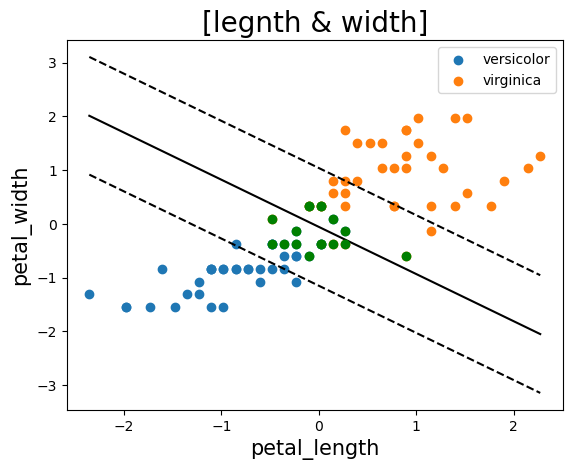

In [77]:
slope = -best_model.coef_[0][0]/best_model.coef_[0][1]
intercept = -best_model.intercept_/best_model.coef_[0][1]

x_data = np.sort(scaled_X_train[:, 0])
y_data = slope * x_data + intercept
species_list = ['versicolor', 'virginica']
for ind in [1, 2]:
    length_data = scaled_X_train[y_train == ind, :][:, 0]
    width_data = scaled_X_train[y_train == ind, :][:, 1]
    plt.scatter(length_data, width_data, label = species_list[ind-1])

plt.plot(x_data, y_data, 'k-')
plt.plot(x_data, y_data + 1/best_model.coef_[0][1], 'k--')
plt.plot(x_data, y_data - 1/best_model.coef_[0][1], 'k--')
plt.plot(sv[0], sv[1], 'go')
plt.title('[legnth & width]', size = 20)
plt.xlabel('petal_length', size = 15)
plt.ylabel('petal_width', size = 15)
plt.legend()
plt.show()

### 결정 트리 활용 <hr>